In [1]:
import json

# Load the dataset
with open("C:/Users/ASUS/Desktop/Project/MS_Project/MMHS150K/MMHS150K_GT.json", 'r') as file:
    data = json.load(file)



In [2]:
#EXECUTE ON SECOND RUN


combined_names_mapping = {
    0: 'Not Hate Speech',
    1: 'Identity-Based',
    2: 'Gender and Sexual Orientation-Based',
    5: 'Other forms of Hate Speech'
}

# Function to combine classes
def combine_classes(original_class):
    if original_class in [1, 4]:  # Combine classes 1 and 4 into 1
        return 1
    elif original_class in [2, 3]:  # Combine classes 2 and 3 into 2
        return 2
    else:
        return original_class  # Keep classes 0 and 5 unchanged

# Apply the combination of classes to each item in the dataset and create a new column 'combined_names_str'
for tweet_id, tweet_data in data.items():
    original_classes = tweet_data['labels']
    combined_classes = [combine_classes(cls) for cls in original_classes]
    tweet_data['combined_labels'] = combined_classes
    # Assign the descriptive name based on the first combined class label (assuming there's at least one label)
    tweet_data['combined_names_str'] = combined_names_mapping.get(combined_classes[0], 'Unknown')


In [3]:
# Load training, validation and test IDs
id_train0 = open("C:/Users/ASUS/Desktop/Project/MS_Project/MMHS150K/splits/train_ids.txt").read()
id_train = id_train0.split()

id_val0 = open("C:/Users/ASUS/Desktop/Project/MS_Project/MMHS150K/splits/val_ids.txt").read()
id_val = id_val0.split()

id_test0 = open("C:/Users/ASUS/Desktop/Project/MS_Project/MMHS150K/splits/test_ids.txt").read()
id_test = id_test0.split()

In [4]:
#data loader
print(json.dumps(list(data.items())[10], indent = 2))



[
  "1116702448016556035",
  {
    "img_url": "http://pbs.twimg.com/tweet_video_thumb/D39S8tbW4AIflmW.jpg",
    "labels": [
      0,
      0,
      0
    ],
    "tweet_url": "https://twitter.com/user/status/1116702448016556035",
    "tweet_text": "@DefNotJerm So.... you turn to twitter for it instead of beating that nigga ass or contacting the police about it? https://t.co/Lseai7IPOL",
    "labels_str": [
      "NotHate",
      "NotHate",
      "NotHate"
    ],
    "combined_labels": [
      0,
      0,
      0
    ],
    "combined_names_str": "Not Hate Speech"
  }
]


In [5]:
#preprocessing
# Create a dataset (list of tweet_text and labels) for each set: training, validation and test
dict_train = {x: data[x] for x in id_train}
dict_val = {x: data[x] for x in id_val}
dict_test = {x: data[x] for x in id_test}

print('Length: %d observations for the train set, %d for the validation and %d for the test.' % 
      (len(dict_train), len(dict_val), len(dict_test)))

Length: 134823 observations for the train set, 5000 for the validation and 10000 for the test.


dict_val

In [ ]:
import matplotlib.pyplot as plt

# Assuming lengths and sets are defined as before
lengths = [len(dict_train), len(dict_val), len(dict_test)]
sets = ['Training', 'Validation', 'Test']

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sets, lengths, color=['blue', 'orange', 'green'])

# Adding title and labels
plt.title('Dataset Distribution')
plt.xlabel('Dataset')
plt.ylabel('Number of Observations')

# Annotate each bar with the number of observations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Display the plot
plt.show()


In [9]:

import pandas as pd
import numpy as np
import json

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import data_clean_proc as dc

In [10]:
#EXECUTE ON SECOND RUN

def extract_text_and_combined_labels(data_dict):
    texts = []
    combined_labels_list = []

    for tweet_id, tweet_data in data_dict.items():
        texts.append(tweet_data['tweet_text'])
        combined_labels_list.append(tweet_data['combined_labels'])

    return texts, combined_labels_list

# Extracting for each dataset
text_train, labels3_train = extract_text_and_combined_labels(dict_train)
text_val, labels3_val = extract_text_and_combined_labels(dict_val)
text_test, labels3_test = extract_text_and_combined_labels(dict_test)


In [38]:
#EXECUTE ON FIRST RUN

def extract_text_and_combined_labels(data_dict):
    texts = []
    combined_labels_list = []

    for tweet_id, tweet_data in data_dict.items():
        texts.append(tweet_data['tweet_text'])
        combined_labels_list.append(tweet_data['labels'])

    return texts, combined_labels_list

# Extracting for each dataset
text_train, labels3_train = extract_text_and_combined_labels(dict_train)
text_val, labels3_val = extract_text_and_combined_labels(dict_val)
text_test, labels3_test = extract_text_and_combined_labels(dict_test)


labels3_train



In [12]:
from collections import Counter
import numpy as np
from random import choice

def custom_majority_vote(annotations):
    """
    Determines a custom majority vote for each data point according to specific rules:
    - If there's no majority and only hate speech classes are present, select randomly among them.
    - If the votes are between two zeros and one hate speech, select 0.
    
    Parameters:
    annotations (list of list of int): The annotations for each data point.
    
    Returns:
    numpy.ndarray: The custom majority class for each data point.
    """
    custom_votes = []

    for annotation in annotations:
        counts = Counter(annotation)
        max_count = max(counts.values())
        candidates = [k for k, v in counts.items() if v == max_count]
        
        # Handle ties specifically according to the new rules
        if len(candidates) > 1:
            # If there's a tie between hate speech classes, choose randomly among them
            # Exclude 0 from the candidates if it's not the only option
            hate_speech_candidates = [c for c in candidates if c != 0]
            if hate_speech_candidates:
                custom_votes.append(choice(hate_speech_candidates))
            else:
                # If all candidates are 0 (which means all annotators agreed on non-hate), append 0
                custom_votes.append(0)
        elif len(set(annotation)) == 3 and counts[0] == 2:
            # If there are two zeros and one hate speech, select 0
            custom_votes.append(0)
        else:
            # In all other cases, append the class with the maximum count
            custom_votes.append(candidates[0])
            
    return np.array(custom_votes)

# Example usage
labels_train = custom_majority_vote(labels3_train)
labels_val = custom_majority_vote(labels3_val)
labels_test = custom_majority_vote(labels3_test)

print(labels_train)
print(np.unique(labels_train))

[1 1 1 ... 0 0 0]
[0 1 2 5]


In [13]:
labels_val[0:10]

array([2, 2, 2, 2, 1, 1, 1, 1, 5, 2])

In [14]:
    # Example of single observations
    print('Final text:', text_val[9])
    print('Final labels:', labels_val[9]) # 1 = Hate

    # Corroborate length or correct implementation
    print('Final text length:', len(text_val))
    print('Final labels length:', len(labels_val))

Final text: A dyke / fem meet up would be dope.  But dykes are historically, hereditarily,  and pathologically broke https://t.co/4zBhxPBpGr
Final labels: 2
Final text length: 5000
Final labels length: 5000


In [15]:
print('Number of tweets:', len(data))

Number of tweets: 149823


In [16]:
all_labels = np.concatenate((labels_train, labels_val, labels_test))

np.set_printoptions(suppress = True)
unique_vals, count_vals = np.unique(all_labels, return_counts = True)
print(np.asarray((unique_vals, count_vals)))

[[     0      1      2      5]
 [112845  15960  11870   9148]]


In [45]:
#Text-Preprocessing


In [17]:
# Tokenizer object
tokens = Tokenizer()
tokens.fit_on_texts(text_train)
print('Total input of documents for tokenizer:', tokens.document_count)

# Train set
# Tokens to number sequences
text_encoded_train = tokens.texts_to_sequences(text_train)

# Padding to a determined length
max_length_tokens = 70 # Maximum characters in tweets is 280, assumption: 70 words (of 4 characters)
text_padded_train = pad_sequences(text_encoded_train,
                            maxlen = max_length_tokens, 
                            padding = 'post') # Padding after sequence

Total input of documents for tokenizer: 134823


In [ ]:
print("Before Padding:")
for seq in text_encoded_train:
    print(seq)

# Apply padding
text_padded_train = pad_sequences(text_encoded_train,
                                  maxlen=max_length_tokens,
                                  padding='post')  # Padding after sequence

# Visualize after padding
print("\nAfter Padding:")
for seq in text_padded_train:
    print(seq)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming text_encoded_train is already defined
max_length_tokens = 70  # As previously mentioned

# Apply padding
text_padded_train = pad_sequences(text_encoded_train, maxlen=max_length_tokens, padding='post')

# Calculate the lengths of original and padded sequences
original_lengths = [len(seq) for seq in text_encoded_train]
padded_lengths = [len(seq) for seq in text_padded_train]

# Visualize the distribution of original sequence lengths
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
counts_orig, bins_orig, _ = plt.hist(original_lengths, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.grid(True)

# Annotations for the original lengths histogram
for i, count in enumerate(counts_orig):
    if count > 0:
        plt.text(bins_orig[i] + (bins_orig[i+1] - bins_orig[i]) / 2, count, str(int(count)),
                 ha='center', va='bottom', fontsize=10, color='black')

# Visualize the distribution of padded sequence lengths
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
counts_padded, bins_padded, _ = plt.hist(padded_lengths, color='lightgreen', edgecolor='black')
plt.title('Distribution of Padded Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.grid(True)

# Annotations for the padded lengths histogram
for i, count in enumerate(counts_padded):
    if count > 0:
        plt.text(bins_padded[i] + (bins_padded[i+1] - bins_padded[i]) / 2, count, str(int(count)),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [20]:
# Validation set
# Tokens to number sequences
text_encoded_val = tokens.texts_to_sequences(text_val)

# Padding to a determined length
text_padded_val = pad_sequences(text_encoded_val,
                            maxlen = max_length_tokens, 
                            padding = 'post') # Padding after sequence

# Test set
# Tokens to number sequences
text_encoded_test = tokens.texts_to_sequences(text_test)

# Padding to a determined length
text_padded_test = pad_sequences(text_encoded_test,
                            maxlen = max_length_tokens, 
                            padding = 'post') # Padding after sequence

In [21]:
#glove embeddings

In [21]:
# Dictionary for embeddings
glove_file_path = "C:/Users/ASUS/Desktop/Project/MS_Project/glove.twitter.27B/glove.twitter.27B.200d.txt"
embed_length = 200 # From glove.twitter.27B.200d.txt (dimensions)

embedding_index = {} # Embedding dictionary
with open(glove_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        temp = line.split()
        word = temp[0]
        coefs = np.asarray(temp[1:], dtype = np.float32)
        embedding_index[word] = coefs # Add word to dictionary with the embedding values

print('Length of word vectors:', len(embedding_index))

Length of word vectors: 1193514


In [22]:
# Weight matrix for training set tokens 
vocab_length = len(tokens.word_index) + 1  
embedding_matrix = np.zeros((vocab_length, embed_length))
 
for word, index in tokens.word_index.items():
  # Search for training set's tokens in the embeddings data
    embedding_vector = embedding_index.get(word)
 
  # If found, add to matrix
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#print(embedding_matrix[1])
print('Dimensions of matrix: %d rows x %d columns' %
      (len(embedding_matrix), len(embedding_matrix[0])))

Dimensions of matrix: 259979 rows x 200 columns


In [23]:
text_padded_train = np.array(text_padded_train, dtype = 'float32')
labels_train = np.array(labels_train, dtype = 'float32')

text_padded_val = np.array(text_padded_val, dtype = 'float32')
labels_val = np.array(labels_val, dtype = 'float32')

text_padded_test = np.array(text_padded_test, dtype = 'float32')
labels_test = np.array(labels_test, dtype = 'float32')

In [54]:
#model-implemmentation

In [24]:
import models as mod
from tensorflow.keras.utils import plot_model
from sklearn.utils import class_weight

In [56]:
#GRU

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.layers import GRU




def model_GRU(units_layer1, units_layer2, vocab_len, embed_len, max_len_tok, embed_mat, n_dropout, bi, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_len, output_dim=embed_len, input_length=max_len_tok,
                        embeddings_initializer=Constant(embed_mat), trainable=False))
    if bi:
        model.add(Bidirectional(GRU(units_layer1, dropout=0.2, recurrent_dropout=0.2)))
    else:
        model.add(GRU(units_layer1, dropout=0.2, recurrent_dropout=0.2))
    model.add(BatchNormalization())
    model.add(Dense(units_layer2, activation='relu'))
    model.add(Dropout(n_dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(np.unique(labels_train)) 
model_gru_multiclass = model_GRU(units_layer1=128, units_layer2=64, vocab_len=vocab_length, embed_len=embed_length,
                                 max_len_tok=max_length_tokens, embed_mat=embedding_matrix, n_dropout=0.3, bi=True, num_classes=num_classes)

In [27]:
print(num_classes)

4


In [60]:
#RUN ON FIRST RUN

from sklearn.utils import class_weight
import numpy as np

# labels_train is properly encoded for multiclass classification (e.g., [0, 1, 2, 3] for 4 classes)
class_weights_arr = class_weight.compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights_arr)}

print(class_weight_dict)
#for 0 to 5 classes

{0: 0.213301881419323, 1: 1.8492716648835488, 2: 4.43993281960087, 3: 5.030333557197224, 4: 44.67296222664016, 5: 3.0802604523646333}


In [27]:
#for 0,1,2,5 classes

from sklearn.utils import class_weight
import numpy as np

# Your unique classes are already identified
unique_classes = np.array([0, 1, 2, 5])

# Compute class weights for these classes
class_weights_arr = class_weight.compute_class_weight('balanced',
                                                      classes=unique_classes,
                                                      y=labels_train)  # Ensure labels_train is a flat array of your labels

# Create a dictionary mapping class labels to their computed weights
class_weight_dict = dict(zip(unique_classes, class_weights_arr))

print("Class weights dictionary:", class_weight_dict)


Class weights dictionary: {0: 0.3199528221289845, 1: 2.6498231132075474, 2: 3.563729118206809, 5: 4.617858610768598}


In [28]:
# Original class weights for non-consecutive labels
original_class_weight_dict = {0: 0.3199528221289845, 1: 2.642759134389211, 2: 3.543125197098707, 5: 4.674861303744799}

# Map the original class labels to consecutive labels {0, 1, 2, 5} -> {0, 1, 2, 3}
class_label_mapping = {0: 0, 1: 1, 2: 2, 5: 3}
mapped_class_weight_dict = {class_label_mapping[key]: value for key, value in original_class_weight_dict.items()}

print("Mapped Class Weights:", mapped_class_weight_dict)


Mapped Class Weights: {0: 0.3199528221289845, 1: 2.642759134389211, 2: 3.543125197098707, 3: 4.674861303744799}


In [29]:
from tensorflow.keras.utils import to_categorical


# Example mapping function
def remap_labels(labels):
    mapping = {0: 0, 1: 1, 2: 2, 5: 3}
    return np.array([mapping[label] for label in labels])

# Apply mapping to your labels
labels_train_mapped = remap_labels(labels_train)  # Assuming labels_train_original is your original labels
labels_val_mapped = remap_labels(labels_val)
labels_test_mapped = remap_labels(labels_test)


labels_val = to_categorical(labels_val_mapped, num_classes=4)
labels_test = to_categorical(labels_test_mapped, num_classes=4)


In [ ]:
#EXECUTE ON FIRST RUN

from tensorflow.keras.utils import to_categorical

labels_train = to_categorical(labels_train, num_classes=6)
labels_val = to_categorical(labels_val, num_classes=6)
labels_test = to_categorical(labels_test, num_classes=6)

In [30]:
# Add callbacks for Early Stopping and Model Checkpointing
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history_gru_multiclass = model_gru_multiclass.fit(text_padded_train, labels_train, batch_size=64, epochs=30,
                                                    validation_data=(text_padded_val, labels_val), shuffle=True,
                                                    class_weight=mapped_class_weight_dict, verbose=1, callbacks=callbacks)

Epoch 1/30


2107/2107 [==============================] - ETA: 0s - loss: 1.0797 - accuracy: 0.4551

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2107/2107 [==============================] - 526s 247ms/step - loss: 1.0797 - accuracy: 0.4551 - val_loss: 1.0738 - val_accuracy: 0.5418
Epoch 2/30
2107/2107 [==============================] - 2498s 1s/step - loss: 1.0125 - accuracy: 0.5141 - val_loss: 1.0885 - val_accuracy: 0.5662
Epoch 3/30
2107/2107 [==============================] - 554s 263ms/step - loss: 0.9998 - accuracy: 0.5275 - val_loss: 1.0500 - val_accuracy: 0.5570
Epoch 4/30
2107/2107 [==============================] - 573s 272ms/step - loss: 0.9900 - accuracy: 0.5243 - val_loss: 1.0309 - val_accuracy: 0.5836
Epoch 5/30
2107/2107 [==============================] - 516s 245ms/step - loss: 0.9773 - accuracy: 0.5224 - val_loss: 1.0713 - val_accuracy: 0.5550
Epoch 6/30
2107/2107 [==============================] - 448s 213ms/step - loss: 0.9620 - accuracy: 0.5160 - val_loss: 1.0746 - val_accuracy: 0.4680
Epoch 7/30
2107/2107 [==============================] - 375s 178ms/step - loss: 0.9519 - accuracy: 0.5161 - val_loss: 1.0493 

In [31]:
# Evaluate the multiclass LSTM model on the test data
model_gru_multiclass_results = model_gru_multiclass.evaluate(text_padded_test, labels_test, verbose=1)


313/313 [==============================] - 3s 10ms/step - loss: 1.0328 - accuracy: 0.5828


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the probabilities for the test set
y_pred_probs = model_gru_multiclass.predict(text_padded_test)

# Convert the probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Since labels_test is one-hot encoded, we also need to convert it back to class labels
y_true = np.argmax(labels_test, axis=1)
print(classification_report(y_true, y_pred))


In [ ]:
pip install matplotlib scikit-learn


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Predict probabilities
y_pred_probs = model_gru_multiclass.predict(text_padded_test)

# Number of classes
n_classes = labels_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_test.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and the micro-average
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()


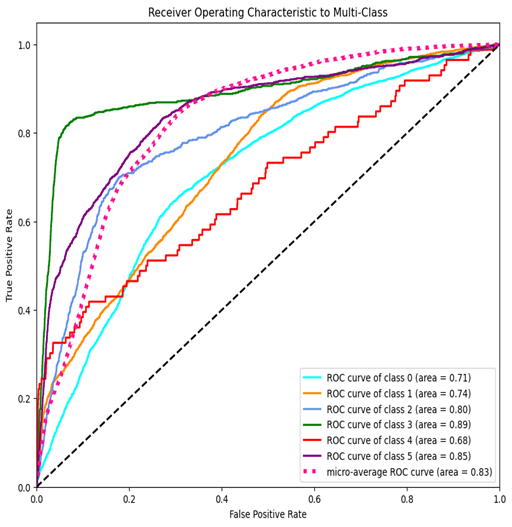

313/313 [==============================] - 3s 9ms/step


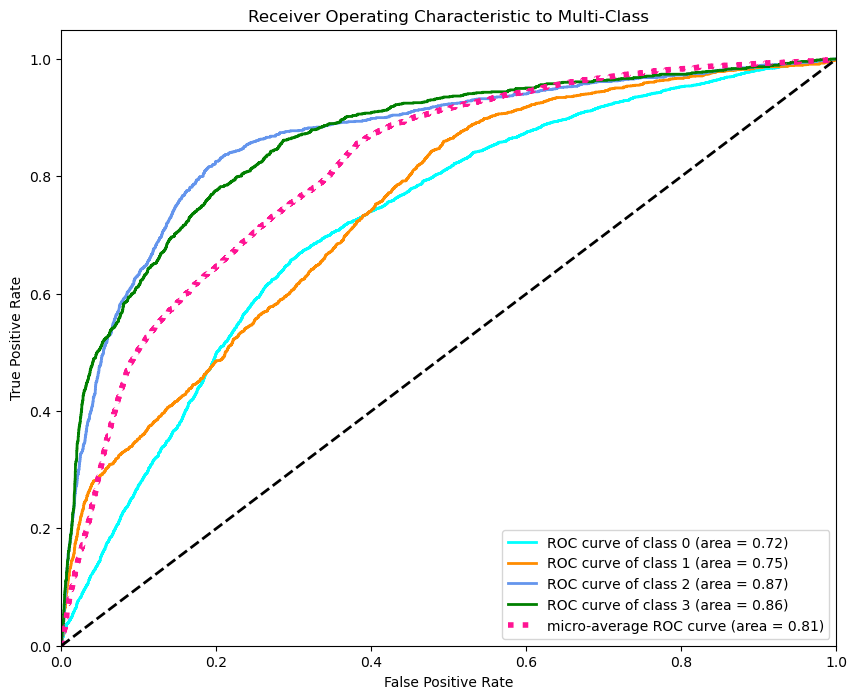

In [33]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Predict probabilities
y_pred_probs = model_gru_multiclass.predict(text_padded_test)

# Number of classes
n_classes = labels_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_test.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and the micro-average
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [42]:
# Predict the probabilities for each class
predictions_prob = model_gru_multiclass.predict(text_padded_val)
# Convert probabilities to class labels
predictions = np.argmax(predictions_prob, axis=1)
# Assuming labels_val are one-hot encoded, get the true labels
true_labels = np.argmax(labels_val, axis=1)


157/157 [==============================] - 2s 10ms/step


In [43]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Optionally, normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


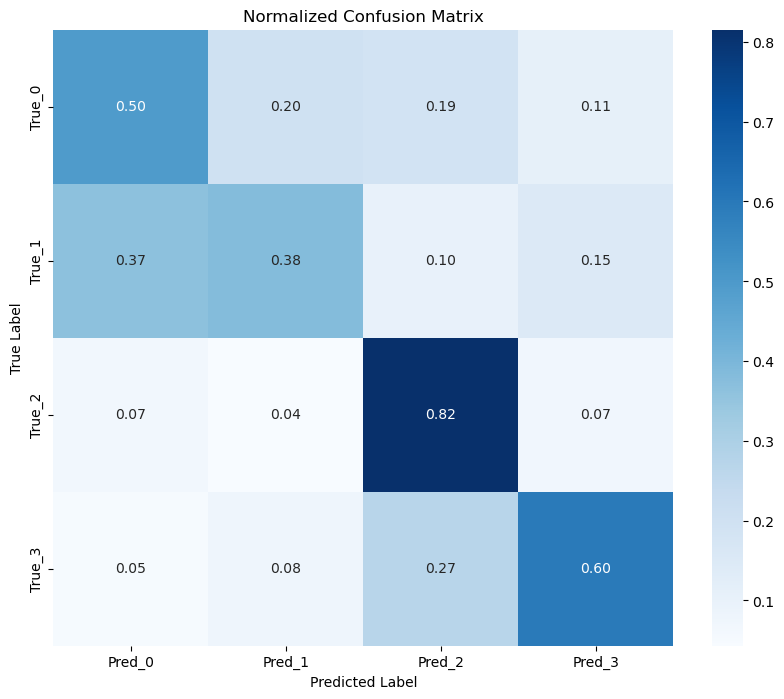

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=[f"Pred_{i}" for i in range(cm.shape[1])], 
            yticklabels=[f"True_{i}" for i in range(cm.shape[0])])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
